In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scikitplot as skplt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

%matplotlib inline

os.getcwd()

'C:\\ProjetosDataScience\\Estudos DOLFUT\\4 - Analises'

In [7]:
file_path = 'C:\\ProjetosDataScience\\Estudos DOLFUT\\2 - Dados Preparados\estudo-gap.csv'
gap = pd.read_csv(file_path, sep=';')

gap.head()

,abe_fec,abe_vwp,abe_aju,gap_qtt,gap_fec
0,0.003437,0.002580,0.000098,14.0,1
1,0.010138,0.005677,0.009260,41.0,1
2,0.006769,0.007025,0.010802,27.5,1
3,-0.006501,-0.001445,-0.006393,-26.5,1
4,-0.000741,-0.002002,-0.003199,-3.0,1


In [8]:
gap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1026 entries, 0 to 1025
Data columns (total 5 columns):
abe_fec    1026 non-null float64
abe_vwp    1026 non-null float64
abe_aju    1026 non-null float64
gap_qtt    1026 non-null float64
gap_fec    1026 non-null int64
dtypes: float64(4), int64(1)
memory usage: 40.2 KB


In [9]:
gap.describe()

,abe_fec,abe_vwp,abe_aju,gap_qtt,gap_fec
count,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000
mean,0.000123,-0.001343,0.000288,0.349903,0.692008
std,0.004965,0.017157,0.005610,17.810079,0.461888
min,-0.030572,-0.336503,-0.035751,-117.000000,0.000000
25%,-0.002284,-0.004669,-0.002448,-8.500000,0.000000
50%,0.000000,0.000020,0.000268,0.000000,1.000000
75%,0.002450,0.004257,0.002796,8.500000,1.000000
max,0.056253,0.066404,0.059982,177.000000,1.000000


In [10]:
gap['gap_fec'].value_counts()

1    710
0    316
Name: gap_fec, dtype: int64

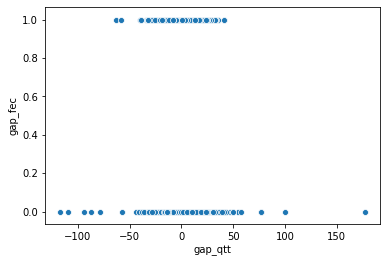

In [12]:
sns.scatterplot('gap_qtt', 'gap_fec', data=gap);

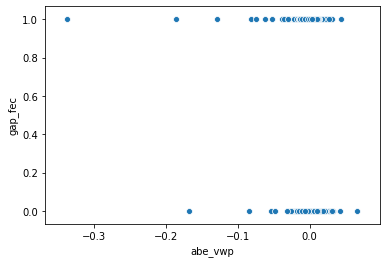

In [14]:
sns.scatterplot('abe_vwp', 'gap_fec', data=gap);

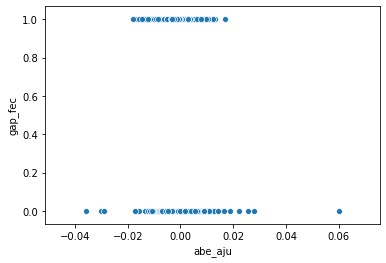

In [16]:
sns.scatterplot('abe_aju', 'gap_fec', data=gap);

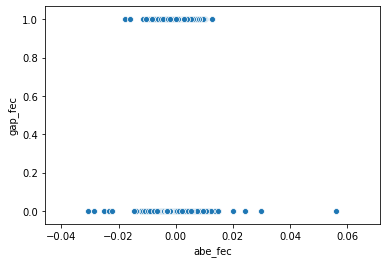

In [18]:
sns.scatterplot('abe_fec', 'gap_fec', data=gap);

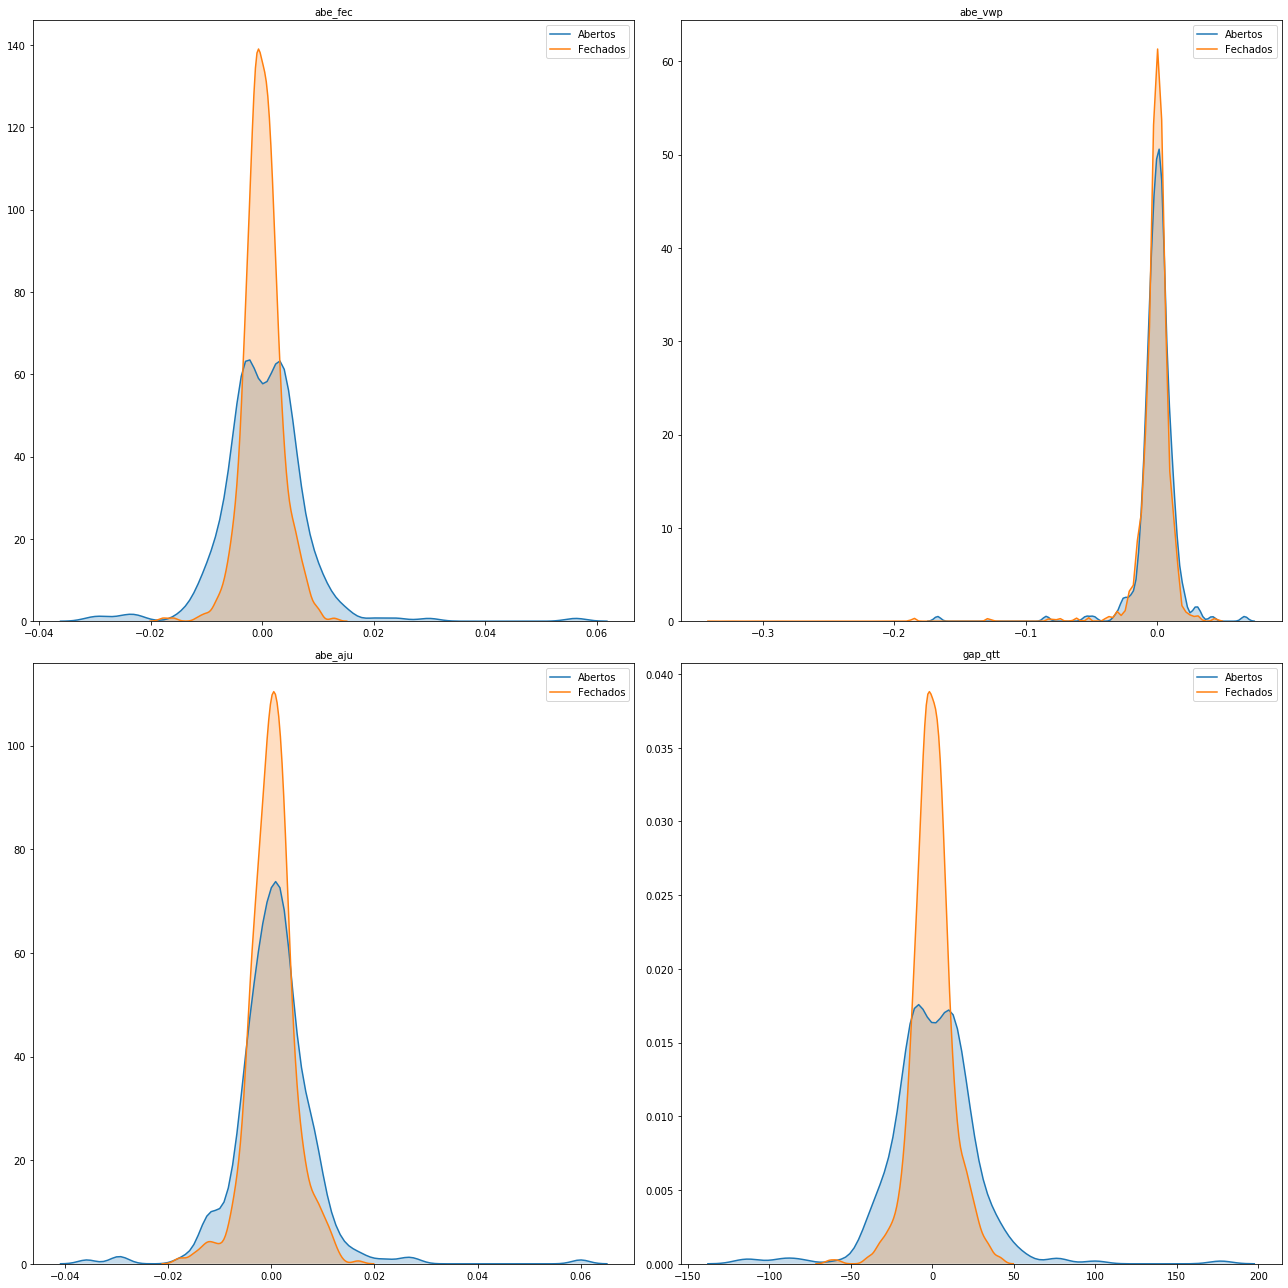

In [20]:
column_names = gap.drop('gap_fec', axis=1).columns


num_plots = len(column_names)


df_0 = gap[gap.gap_fec==0]
df_1 = gap[gap.gap_fec==1]

# criando objeto gráfico
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
fig.subplots_adjust(hspace=1, wspace=1)

# criando estrutura de repetição para automatizar a plotagem dos gráficos
idx = 0

for col in column_names:
    idx += 1
    plt.subplot(2,2, idx)
    sns.kdeplot(df_0[col], label = 'Abertos', shade=True)
    sns.kdeplot(df_1[col], label = 'Fechados', shade=True)
    plt.title(col, fontsize=10)
plt.tight_layout()

In [22]:
# normalizar os valores que estão em diferentes ordens de grandeza
scaled_df = gap.copy()

num_cols = scaled_df.drop('gap_fec', axis=1).columns

scaled_df[num_cols] = StandardScaler().fit_transform(scaled_df[num_cols].values)
scaled_df.describe()

,abe_fec,abe_vwp,abe_aju,gap_qtt,gap_fec
count,1.026000e+03,1.026000e+03,1.026000e+03,1.026000e+03,1026.000000
mean,-2.697825e-17,-8.494396e-18,1.991043e-17,5.270110e-18,0.692008
std,1.000488e+00,1.000488e+00,1.000488e+00,1.000488e+00,0.461888
min,-6.184991e+00,-1.954499e+01,-6.427049e+00,-6.592174e+00,0.000000
25%,-4.849495e-01,-1.939280e-01,-4.879582e-01,-4.971465e-01,0.000000
50%,-2.477490e-02,7.947682e-02,-3.625425e-03,-1.965590e-02,1.000000
75%,4.688843e-01,3.265784e-01,4.471937e-01,4.578347e-01,1.000000
max,1.131003e+01,3.950672e+00,1.064560e+01,9.923384e+00,1.000000


In [23]:
# separar os dados em dados de treino e teste
# separar variáveis alvo e explanatórias
X = scaled_df.drop('gap_fec', axis=1)
y = scaled_df['gap_fec']

# dividir o conjunto entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, test_size=0.25, random_state=220)

1    532
0    237
Name: gap_fec, dtype: int64


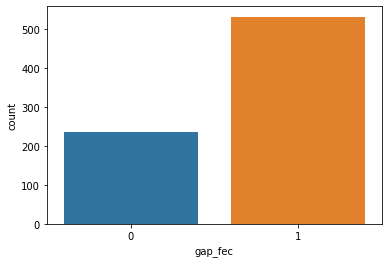

In [25]:
# verificar balanceamento dos dados
print(pd.Series(y_train).value_counts())

sns.countplot(y_train);

1    237
0    237
Name: gap_fec, dtype: int64


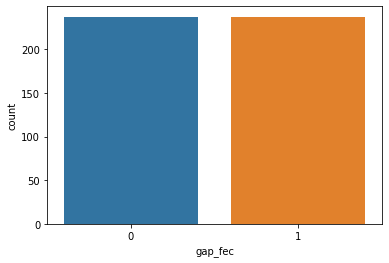

In [26]:
# rebalancear usando udersampling
rus = RandomUnderSampler(random_state=220)
X_rus, y_rus = rus.fit_sample(X_train, y_train)

# ver o balanceamento das classes
print(pd.Series(y_rus).value_counts())

sns.countplot(y_rus);

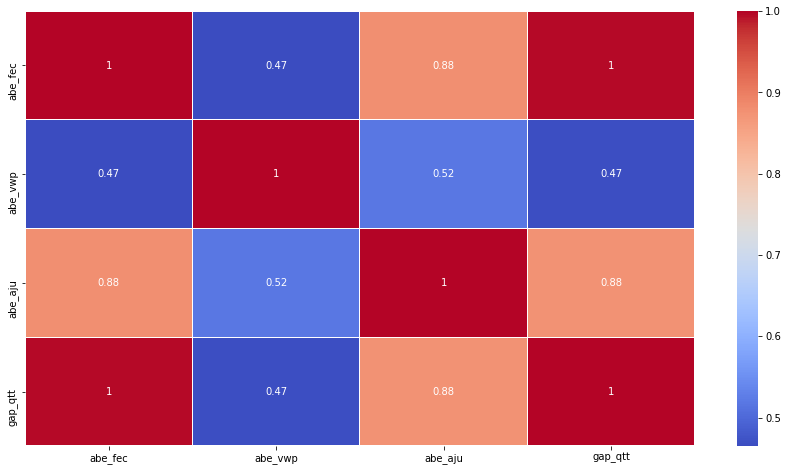

In [27]:
# criar matriz de correlação
corr = pd.DataFrame(X_rus).corr()

# plotar matriz de correlação
fig, ax = plt.subplots(figsize=(15,8))

sns.heatmap(corr, xticklabels=corr.columns, annot=True, yticklabels=corr.columns, linewidths=0.1, cmap='coolwarm', ax=ax);

In [29]:
# instanciar um modelo de regressão logística
model_rus = LogisticRegression(random_state=220)

# treinar modelo
model_rus.fit(X_rus, y_rus)

# gerar predições em cima do conjunto de teste
y_pred_rus = model_rus.predict(X_test)
y_prob_rus = model_rus.predict_proba(X_test)

Relatório de Classificação: 
               precision    recall  f1-score   support

           0       0.29      0.54      0.38        79
           1       0.67      0.42      0.51       178

    accuracy                           0.46       257
   macro avg       0.48      0.48      0.45       257
weighted avg       0.56      0.46      0.47       257

Acurácia: 0.46


AUC: 0.48

1    178
0     79
Name: gap_fec, dtype: int64 



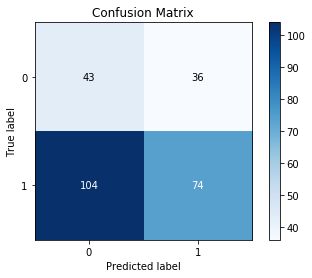

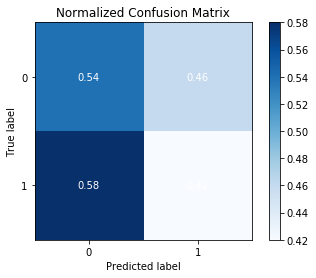

In [31]:
# plotar a matriz de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred_rus, normalize=False)
skplt.metrics.plot_confusion_matrix(y_test, y_pred_rus, normalize=True)

# imprimir o relatório de classificação
print('Relatório de Classificação: \n', classification_report(y_test, y_pred_rus, digits=2))

# imprimir acurácia
print('Acurácia: {:.2}\n'.format(accuracy_score(y_test, y_pred_rus)))

# imprimir área sob curva
print('\nAUC: {:.2}\n'.format(roc_auc_score(y_test, y_pred_rus)))

# imprimir total de ativos e inativos
print(y_test.value_counts(),'\n')

In [36]:
parametros = {'learning_rate':[0.01,0.1], 'n_estimators':[100,250,500,750,1000],
                         'max_depth':[1,3], 'subsample':[0.1,1],
                         'colsample_bytree':[0.1,0.5], 'gamma':[0,1],
                         'random_state':[40,70,220]}
xgb = XGBClassifier()
grid = GridSearchCV(xgb, parametros)

In [37]:
grid.fit(X_rus, y_rus)

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale...ht=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.1, 0.5], 'gamma': [0, 1],
                         'learning_rate': [0.01, 0.1], 'max_depth': [1, 3],
                         'n_es

In [39]:
grid.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 1,
 'n_estimators': 1000,
 'random_state': 40,
 'subsample': 0.1}

In [40]:
# testar XGBoostClassifier
from xgboost import XGBClassifier

# instanciar e treinar o modelo XGB para os dados balanceados
XGB_model = XGBClassifier(learning_rate=0.1, n_estimators=1000,
                         max_depth=1, subsample=0.1,
                         colsample_bytree=0.5, gamma=0,
                         random_state=220)

# fittar o modelo aos dados balanceados
XGB_model.fit(X_rus, y_rus)

# predizer conforme treinamento em base balanceada
y_xgb_rus = XGB_model.predict(X_test)

Relatório de Classificação: 
               precision    recall  f1-score   support

           0       0.44      0.76      0.56        79
           1       0.84      0.58      0.69       178

    accuracy                           0.63       257
   macro avg       0.64      0.67      0.62       257
weighted avg       0.72      0.63      0.65       257

Acurácia: 0.63

AUC: 0.67

1    178
0     79
Name: gap_fec, dtype: int64 



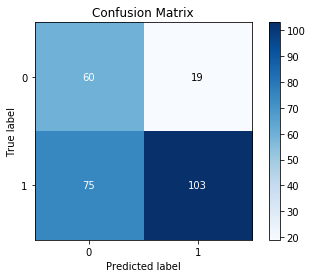

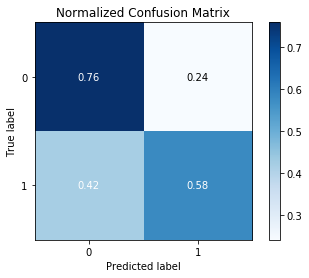

In [41]:
# plotar a matriz de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_xgb_rus, normalize=False)
skplt.metrics.plot_confusion_matrix(y_test, y_xgb_rus, normalize=True)

# imprimir o relatório de classificação
print('Relatório de Classificação: \n', classification_report(y_test, y_xgb_rus, digits=2))

# imprimir acurácia
print('Acurácia: {:.2}\n'.format(accuracy_score(y_test, y_xgb_rus)))

# imprimir área sob curva
print('AUC: {:.2}\n'.format(roc_auc_score(y_test, y_xgb_rus)))

# imprimir total de ativos e inativos
print(y_test.value_counts(),'\n')

### Conclusão 

* É possível predizer (com acurácia baixa, porém melhor que aleatório e área sob a curva razoável) se um gap fechará ou não, na hora da abertura de acordo com as variáveis:
    * variação percentual da abertura d0 para o fechamento d-1
    * variação percentual da abertura d0 para o ajuste d-1
    * variação percentual da abertura d0 para a vwap semanal d-1
    * variação quantitativa da abertura d0 para o fechamento d-1 (tamanho do gap)

Provavelmente vou testar novas variáveis em breve, como volume, saldo de agressão e outras que imaginar futuramente.